<a href="https://colab.research.google.com/github/Yuri-Vlasqz/MVP-Sistemas-Inteligentes/blob/main/api/MachineLearning/notebooks/dengue_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploração de Dataset Original:** *Infodengue-Mosqlimate Dengue 2025*
O dataset original foi obtido na **2ª edição da Sprint de Previsão de Dengue**, promovida pela Mosqlimate e Infodengue, com apoio dos projetos Harmonize e IDExtremes, com objetivo de incentivar a criação e validação de modelos preditivos para estimar casos prováveis de dengue no Brasil.
<div>
<img src="https://sprint.mosqlimate.org/logo-medium.png" width="200" title="IMDC Logo"/>
</div>

> **Link:** *2nd Infodengue-Mosqlimate Dengue Challenge (IMDC)*: https://sprint.mosqlimate.org/

<br>

---
## 🔍Entendendo a estrutura e conteúdo dos arquivos do dataset original

### 1. `dengue.csv` 🦟 – Séries semanais de casos

* **Período:** semana epidemiológica (epiweek) de 2010‑01 até 2025‑17 (EW 17/2025).
* **Nível:** casos agregados por semana e município.
* **Colunas principais:** *`date`, `epiweek`, `geocode`, `casos` (casos prováveis),* `regional_geocode`, `macroregional_geocode`, `uf`.



### 2. `climate.csv` ⛅ – Reanálise climática semanal

* **Período:** epiweek 201001 até 202517.
* **Dados:** reanálise ERA5 (Copernicus), agregados da hora → por dia → por semana.
* **Colunas:** `date`, `epiweek`, `geocode`, `temp_min/med/max`, `precip_min/med/max`,
  `pressure_min/med/max`, `rel_humid_min/med/max`, `thermal_range` e `rainy_days`.



### 3. `climate_forecast.csv` 🔮 – Previsões climáticas mensais

* **Período:** janeiro de 2010 a abril de 2025.
* **Conteúdo:** previsões de temperatura, precipitação e umidade relativa para até 6 meses à frente.
* **Colunas:** `geocode`, `reference_month`, `forecast_months_ahead`, `temp_med`, `precip_tot`, `rel_humid_med`.



### 4. `ocean_climate_oscillations.csv` 🌊 – Oscilações oceânicas semanais

* **Período:** 1993‑01‑04 até 2025‑03‑03.
* **Parâmetros incluídos:** índices ENSO (El Niño / La Niña), IOD (Indian Ocean Dipole), PDO (Pacific Decadal Oscillation), semana por data.



### 5. `environ_vars.csv` 🍃 – Variáveis ambientais por município

* **Dados de 2010 e 2024.**
* **Inclui:** código IBGE, tipo climático de Koppen, biome, entre outros.



### 6. `shape_muni.gpkg` 📐 – Geometria municipal

* **Formato:** shapefile geopackage (formato GPKG).
* **Colunas importantes:** `geocode`, `geocode_name`, `uf`, `uf_code`, `geometry`.



### 7. `map_regional_health.csv` 📍 – Mapeamento regional/saúde

* Vínculo entre município, UF, região, regional e macrorregional de saúde.
* **Inclui:** `macroregion_code/name`, `macroregional_geocode/name`, `regional_geocode/name`, e `uf_code/name` e `geocode/name`(município).



### 8. `datasus_population_2001_2024.csv` 📊 – População municipal histórica

* Números anuais de população por município entre 2001 e 2024.
* Colunas: `geocode`, `year`, `population`.

<br>

---
## 📥 Instruções para importar dataset original para este Notebook no Colab:

1. Baixe o dataset original - Instruções para baixar Dataset original: https://sprint.mosqlimate.org/data/

2.  Extraia, em seu PC, no caminho do arquivo baixado `mftp_zip_2025_07_05_12_48_23.zip\data_sprint_2025\` os seguintes arquivos do dataset:
    - dengue.csv.gz ➡️ dengue.csv.
    - climate.csv.gz ➡️ climate.csv
    - map_regional_health.csv (já está em formato necessário)
    - datasus_population_2001_2024.csv.gz ➡️ datasus_population_2001_2024.csv

3. Crie a pasta `Datasets\` no ambiente do notebook e coloque os arquivos extraidos nela:
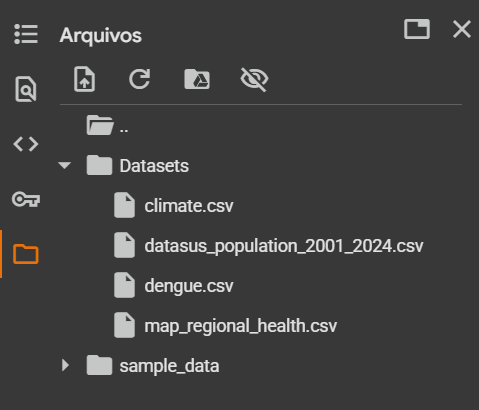

> **OBS**:
- Arquivos serão excluídos após se desconectar da sessão do notebook
- para rodar localmente basta modificar a variável `DATASET_PATH` para o caminho da pasta com os arquivos.csv's

<br>

---
## 📤 Exportação do dataset pré-processado:
O dataset de arquivo único `dataset_com_casos_2020_2024.csv`, que será utilizado para treinamento do classificador no notebook `dengue_model_classification.ipynb`, será exportado ao final deste notebook após seu pré-processamento.

<br>

---

# 💻 Execução do Notebook abaixo:
---

In [ ]:
# Descomente para instalar bibliotecas se estiver usando notebook localmente!
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn
# !pip install tqdm

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
import time

# Imports necessários
from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# Pandas
pd.set_option("display.max_columns", None)
# pd.reset_option("display.max_columns")

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Váriaveis globais
# TODO: mudar para caminho relativo
DATASET_PATH = "/content/Datasets"

___
# 📖 Leitura dos dados
___

In [ ]:
def read_datasets(path: str, dataset_files: list[str], dataset_names: list[str]) -> set:
    """
    Lê e armazena arquivos csv em dicionário de dataframes.
    """
    display(Markdown(f"### **Lendo arquivos** `{dataset_files}`"))
    start = time.time()
    datasets_dict = {}
    for data_file, data_name in zip(dataset_files, dataset_names):
        # datasets.append(pd.read_csv(path + "/" + data_file))
        datasets_dict[data_name] = pd.read_csv(path + "/" + data_file)
        display(Markdown(f"- ### {data_file} importado como: `{data_name} {datasets_dict[data_name].shape}`"))
        # print(f"--- {data_file} importado como: {data_name} {datasets_dict[data_name].shape}")
        display(datasets_dict[data_name].head(1))

    end = time.time()
    print(f"\nLeitura de {len(datasets_dict)} arquivos feita em: {round((end - start), 2)} segundos")

    return datasets_dict

In [ ]:
datasets = read_datasets(DATASET_PATH, ["dengue.csv", "climate.csv", "map_regional_health.csv", "datasus_population_2001_2024.csv"], ["dengue_df", "clima_df", "regional_df", "population_df"])

### **Lendo arquivos** `['dengue.csv', 'climate.csv', 'map_regional_health.csv', 'datasus_population_2001_2024.csv']`

- ### dengue.csv importado como: `dengue_df (4471809, 13)`

,date,epiweek,geocode,casos,uf,macroregional_geocode,regional_geocode,train_1,target_1,train_2,target_2,train_3,target_3
0,2010-01-03,201001,1100015,3,RO,1101,11005,True,False,True,False,True,False


- ### climate.csv importado como: `clima_df (4453600, 17)`

,date,epiweek,geocode,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,pressure_min,pressure_med,pressure_max,rel_humid_min,rel_humid_med,rel_humid_max,thermal_range,rainy_days
0,2009-12-27,200952,2700102,22.2044,25.44435,29.91435,2.0215,6.4583,14.3808,0.95505,0.9577,0.95945,53.97185,75.81715,93.8575,7.70995,2


- ### map_regional_health.csv importado como: `regional_df (5570, 11)`

,macroregion_code,macroregion_name,uf_code,uf,uf_name,macroregional_geocode,macroregional_name,regional_geocode,regional_name,geocode,geocode_name
0,1,Norte,12,AC,Acre,1201,MACRO UNICA - AC,12002,BAIXO ACRE E PURUS,1200013,AC - ACRELANDIA


- ### datasus_population_2001_2024.csv importado como: `population_df (133680, 3)`

,geocode,year,population
0,1100015,2001,26553



Leitura de 4 arquivos feita em: 22.62 segundos


In [ ]:
# individual dataset structure
for key in datasets.keys():
    print(50*'_')
    print(f'\n{key}')
    display(datasets[key].info(memory_usage=False))

__________________________________________________

dengue_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471809 entries, 0 to 4471808
Data columns (total 13 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   date                   object
 1   epiweek                int64 
 2   geocode                int64 
 3   casos                  int64 
 4   uf                     object
 5   macroregional_geocode  int64 
 6   regional_geocode       int64 
 7   train_1                bool  
 8   target_1               bool  
 9   train_2                bool  
 10  target_2               bool  
 11  train_3                bool  
 12  target_3               bool  
dtypes: bool(6), int64(5), object(2)

None

__________________________________________________

clima_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4453600 entries, 0 to 4453599
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date           object 
 1   epiweek        int64  
 2   geocode        int64  
 3   temp_min       float64
 4   temp_med       float64
 5   temp_max       float64
 6   precip_min     float64
 7   precip_med     float64
 8   precip_max     float64
 9   pressure_min   float64
 10  pressure_med   float64
 11  pressure_max   float64
 12  rel_humid_min  float64
 13  rel_humid_med  float64
 14  rel_humid_max  float64
 15  thermal_range  float64
 16  rainy_days     int64  
dtypes: float64(13), int64(3), object(1)

None

__________________________________________________

regional_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   macroregion_code       5570 non-null   int64 
 1   macroregion_name       5570 non-null   object
 2   uf_code                5570 non-null   int64 
 3   uf                     5570 non-null   object
 4   uf_name                5570 non-null   object
 5   macroregional_geocode  5570 non-null   int64 
 6   macroregional_name     5570 non-null   object
 7   regional_geocode       5570 non-null   int64 
 8   regional_name          5570 non-null   object
 9   geocode                5570 non-null   int64 
 10  geocode_name           5570 non-null   object
dtypes: int64(5), object(6)

None

__________________________________________________

population_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133680 entries, 0 to 133679
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   geocode     133680 non-null  int64
 1   year        133680 non-null  int64
 2   population  133680 non-null  int64
dtypes: int64(3)

None

In [ ]:
def missing_values(dataset):
    """
    It reads a dataframe and check Missing Values.

    Parameters
    ------
        dataset: dataframe
            Table with dataset to be checked.

    Returns
    ------
        MissingSummary: dataframe
            Table with missing values statistics.

    Examples
    ------
        nulls_data = missing_values(dataset)
    """

    categories = []
    null_list = []
    null_percent = []

    for column in dataset:
        categories.append(column)
        null_list.append(dataset[column].isnull().sum())
        null_percent.append(round( (null_list[-1] / dataset.shape[0]) *100, 3))

    nulls_data = pd.DataFrame({'Field Name': categories, 'Total Missing Values': null_list,
                               'Missing Percentage': null_percent})
    print(f'Dataset shape: {dataset.shape[0]} rows x {dataset.shape[1]} columns')

    return nulls_data

In [ ]:
# Displaying missing values from all datasets
for key in datasets.keys():
    print(60*'_')
    print(f'\n{key}')
    display(missing_values(datasets[key]))

____________________________________________________________

dengue_df
Dataset shape: 4471809 rows x 13 columns


,Field Name,Total Missing Values,Missing Percentage
0,date,0,0.0
1,epiweek,0,0.0
2,geocode,0,0.0
3,casos,0,0.0
4,uf,0,0.0
5,macroregional_geocode,0,0.0
6,regional_geocode,0,0.0
7,train_1,0,0.0
8,target_1,0,0.0
9,train_2,0,0.0


____________________________________________________________

clima_df
Dataset shape: 4453600 rows x 17 columns


,Field Name,Total Missing Values,Missing Percentage
0,date,0,0.0
1,epiweek,0,0.0
2,geocode,0,0.0
3,temp_min,0,0.0
4,temp_med,0,0.0
5,temp_max,0,0.0
6,precip_min,0,0.0
7,precip_med,0,0.0
8,precip_max,0,0.0
9,pressure_min,0,0.0


____________________________________________________________

regional_df
Dataset shape: 5570 rows x 11 columns


,Field Name,Total Missing Values,Missing Percentage
0,macroregion_code,0,0.0
1,macroregion_name,0,0.0
2,uf_code,0,0.0
3,uf,0,0.0
4,uf_name,0,0.0
5,macroregional_geocode,0,0.0
6,macroregional_name,0,0.0
7,regional_geocode,0,0.0
8,regional_name,0,0.0
9,geocode,0,0.0


____________________________________________________________

population_df
Dataset shape: 133680 rows x 3 columns


,Field Name,Total Missing Values,Missing Percentage
0,geocode,0,0.0
1,year,0,0.0
2,population,0,0.0


In [ ]:
casos_zerados = datasets['dengue_df'][datasets['dengue_df']['casos'] == 0]
casos_nao_zerados = datasets['dengue_df'][datasets['dengue_df']['casos'] > 0]
print(f"Casos Zerados: {casos_zerados.shape[0]}\nCasos Não Zerados: {casos_nao_zerados.shape[0]}")

Casos Zerados: 3502215
Casos Não Zerados: 969594


___
# 🔗 Mesclagem dos dados em tabela única
___


In [ ]:
# Mesclar os dataframes
# dengue_df + clima_df
merged_df = pd.merge(datasets['dengue_df'], datasets['clima_df'], on=['epiweek', 'geocode'], how='inner', suffixes=('_dengue', '_clima'))
perda_dengue = len(datasets['dengue_df']) - len(merged_df)
perda_clima = len(datasets['clima_df']) - len(merged_df)
tamanho_anterior = len(merged_df)

# merged_df + regional_df
merged_df = pd.merge(merged_df, datasets['regional_df'], on='geocode', how='left')
perda_regional = tamanho_anterior - len(merged_df)
tamanho_anterior = len(merged_df)

# Tratamento de colunas
merged_df = merged_df.drop(columns=['date_clima', 'train_1', 'train_2', 'train_3', 'target_1', 'target_2', 'target_3', 'uf_y', 'macroregional_geocode_y', 'regional_geocode_y'])
merged_df.rename(columns={'date_dengue': 'date', 'uf_x': 'uf', 'macroregional_geocode_x': 'macroregional_geocode', 'regional_geocode_x':	'regional_geocode'}, inplace=True)
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['year'] = merged_df['date'].dt.year
# Extrair semana epidemiológica
merged_df['week'] = merged_df['epiweek'] % 100

# merged_df + population_df
final_df = pd.merge(merged_df, datasets['population_df'], on=['year', 'geocode'], how='inner')
perda_datasus = tamanho_anterior - len(final_df)

print("Shape do dataframe final:", final_df.shape)
# Verificar se há dados perdidos no merge
print(f"\nPerda de dados no merge: \n\
> -{perda_dengue} casos de dengue ao mergir\n\
> -{perda_clima} registros de clima ao mergir\n\
> -{perda_regional} ao mergir com regional\n\
> -{perda_datasus} ao mergir com datasus\n")
# print("\nColunas do dataframe final:")
# print(final_df.columns.tolist())
# print("\nInformações do dataframe final:")
# print(final_df.info())
final_df.head()

Shape do dataframe final: (4352490, 31)

Perda de dados no merge: 
> -30247 casos de dengue ao mergir
> -12038 registros de clima ao mergir
> -0 ao mergir com regional
> -89072 ao mergir com datasus



,date,epiweek,geocode,casos,uf,macroregional_geocode,regional_geocode,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,pressure_min,pressure_med,pressure_max,rel_humid_min,rel_humid_med,rel_humid_max,thermal_range,rainy_days,macroregion_code,macroregion_name,uf_code,uf_name,macroregional_name,regional_name,geocode_name,year,week,population
0,2010-01-03,201001,1100015,3,RO,1101,11005,23.460957,25.731929,29.053014,0.0221,18.3778,59.9157,0.965743,0.968300,0.970229,71.749971,86.902671,95.389571,5.592057,7,1,Norte,11,Rondônia,MACRORREGIONAL II (CACOAL),ZONA DA MATA,RO - ALTA FLORESTA D'OESTE,2010,1,25094
1,2010-01-03,201001,1100023,12,RO,1102,11001,23.354714,25.793914,29.488800,0.3924,24.4080,58.0997,0.974343,0.977143,0.979286,71.403171,88.370043,98.195043,6.134086,7,1,Norte,11,Rondônia,MACRORREGIAO I - PORTO VELHO,VALE DO JAMARI,RO - ARIQUEMES,2010,1,91527
2,2010-01-03,201001,1100031,2,RO,1101,11006,22.937714,25.796386,29.706529,1.8182,28.1681,91.4991,0.964600,0.967300,0.969200,68.665829,86.392229,97.280429,6.768814,7,1,Norte,11,Rondônia,MACRORREGIONAL II (CACOAL),CONE SUL,RO - CABIXI,2010,1,6536
3,2010-01-03,201001,1100049,159,RO,1101,11002,22.699557,24.925514,28.103543,1.4217,25.2290,71.5170,0.967086,0.969671,0.971671,77.417171,91.066829,98.929643,5.403986,7,1,Norte,11,Rondônia,MACRORREGIONAL II (CACOAL),CAFE,RO - CACOAL,2010,1,79624
4,2010-01-03,201001,1100056,9,RO,1101,11006,23.437286,26.099871,29.795743,0.3049,20.2161,71.7226,0.970657,0.973343,0.975257,70.275029,86.118386,95.570157,6.358457,7,1,Norte,11,Rondônia,MACRORREGIONAL II (CACOAL),CONE SUL,RO - CEREJEIRAS,2010,1,17440


In [ ]:
final_df_nao_nulo = final_df[final_df['casos'] > 0]

In [ ]:
def resumo_estatistico(df):
    print("="*24)
    print("=  RESUMO ESTATÍSTICO  =")
    print("="*24)
    print(f"Dataset final: {len(df):,} registros semanais".replace(',', '.'))
    print(f"Total de casos de dengue: {df['casos'].sum():,}".replace(',', '.'))
    print(f"Período: {df['date'].min().date()} (semana {str(df['epiweek'].min())[-2:]}) até {df['date'].max().date()} (semana {str(df['epiweek'].max())[-2:]})")
    print(f"Geografia: {df['geocode'].nunique()} municípios únicos de {df['uf'].nunique()} estados em {df['macroregion_code'].nunique()} regiões")
    print(f"Média de casos por registro: {df['casos'].mean():.1f} (±{df['casos'].std():.1f})".replace('.', ','))
    print(f"Média semanal de casos: {df.groupby('date')['casos'].sum().mean():.1f} (±{df.groupby('date')['casos'].sum().std():.1f})".replace('.', ','))

In [ ]:
resumo_estatistico(final_df)

=  RESUMO ESTATÍSTICO  =
Dataset final: 4.352.490 registros semanais
Total de casos de dengue: 21.154.635
Período: 2010-01-03 (semana 01) até 2024-12-29 (semana 01)
Geografia: 5567 municípios únicos de 27 estados em 5 regiões
Média de casos por registro: 4,9 (±113,0)
Média semanal de casos: 27017,4 (±54086,8)


In [ ]:
resumo_estatistico(final_df_nao_nulo)

=  RESUMO ESTATÍSTICO  =
Dataset final: 919.434 registros semanais
Total de casos de dengue: 21.154.635
Período: 2010-01-03 (semana 01) até 2024-12-29 (semana 01)
Geografia: 5528 municípios únicos de 27 estados em 5 regiões
Média de casos por registro: 23,0 (±245,0)
Média semanal de casos: 27017,4 (±54086,8)


___
# 📈 Gráficos exploratórios
___

In [ ]:
def criar_analise_temporal(df, semanas_media_movel=12):

    # Preparação dos dados
    df_temp = df.copy()

    # Criar figura com subplots
    fig, axes = plt.subplots(2, figsize=(20, 16))
    fig.suptitle('Análise Temporal de Casos', fontsize=20, fontweight='bold')

    # 1. Série temporal geral (casos por data)
    casos_por_data = df_temp.groupby('date')['casos'].sum().reset_index()

    axes[0].plot(casos_por_data['date'], casos_por_data['casos'],
                   linewidth=2, alpha=0.9, color='darkblue')
    axes[0].set_title('Evolução Temporal dos Casos', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Data', fontsize=12)
    axes[0].set_ylabel('Número de Casos', fontsize=12)
    axes[0].grid(True, alpha=0.3)

    # Adicionar média móvel
    casos_por_data['media_movel'] = casos_por_data['casos'].rolling(window=semanas_media_movel, center=True).mean()
    axes[0].plot(casos_por_data['date'], casos_por_data['media_movel'],
                   linewidth=3, alpha=0.5, color='red', label=f'Média Móvel {semanas_media_movel} semanas')
    axes[0].legend()

    # 2. Sazonalidade semanal (últimos 2 dígitos da epiweek)
    casos_por_semana = df_temp.groupby('week')['casos'].sum().reset_index()

    axes[1].bar(casos_por_semana['week'], casos_por_semana['casos'],
                  alpha=0.7, color='darkgreen')
    axes[1].set_title('Sazonalidade Semanal (Semanas 1-53)', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Semana do Ano', fontsize=12)
    axes[1].set_ylabel('Total de Casos (em Milhões)', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='y')

    # Destacar picos sazonais
    media_casos = casos_por_semana['casos'].mean()
    axes[1].axhline(y=media_casos, color='red', linestyle='--',
                      alpha=0.8, label=f'Média: {media_casos:,.0f}'.replace(',', '.'))
    axes[1].legend()

    # plt.tight_layout()
    plt.show()

    return casos_por_data, casos_por_semana

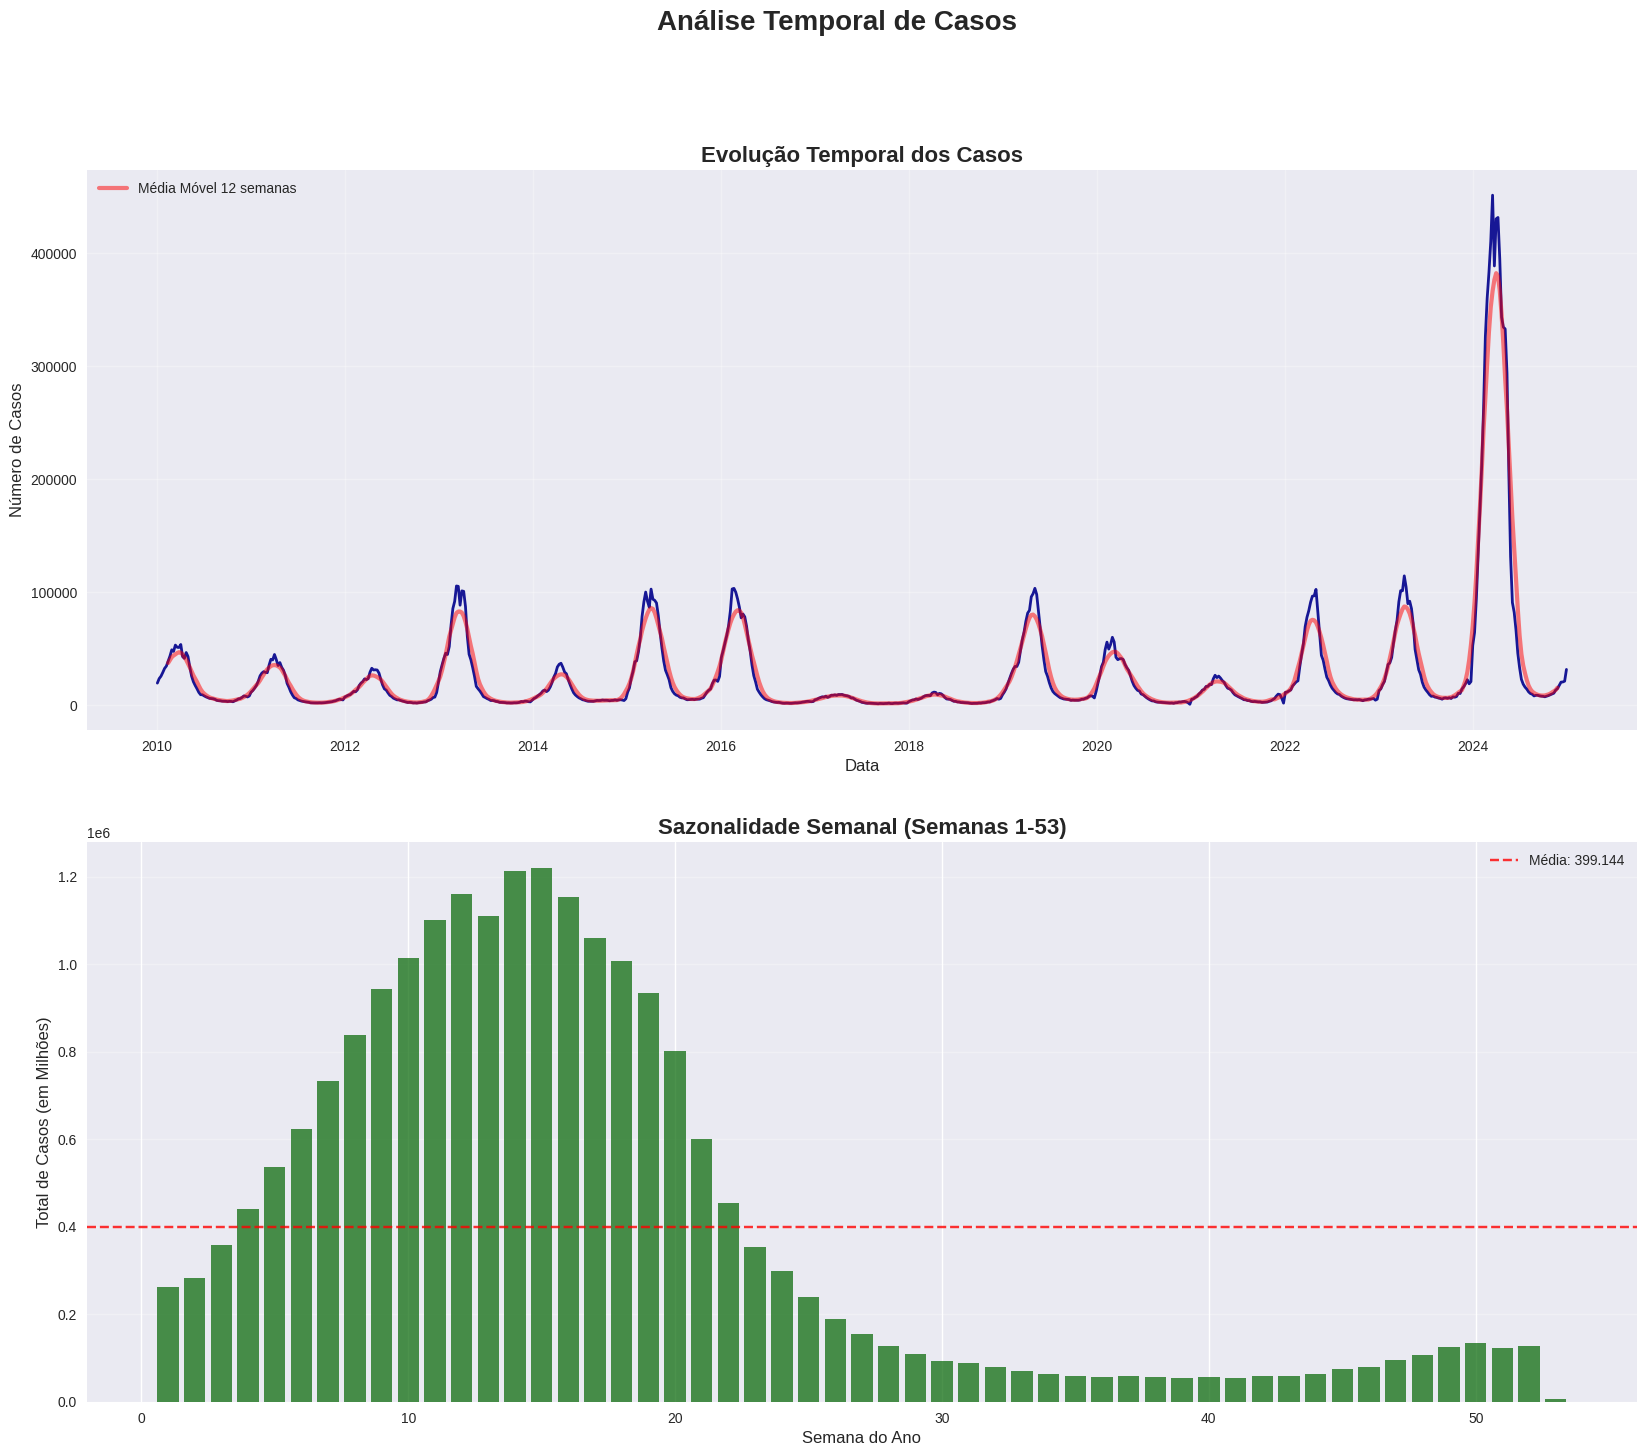

In [ ]:
# Executar análise completa
casos_data, casos_semana = criar_analise_temporal(final_df)

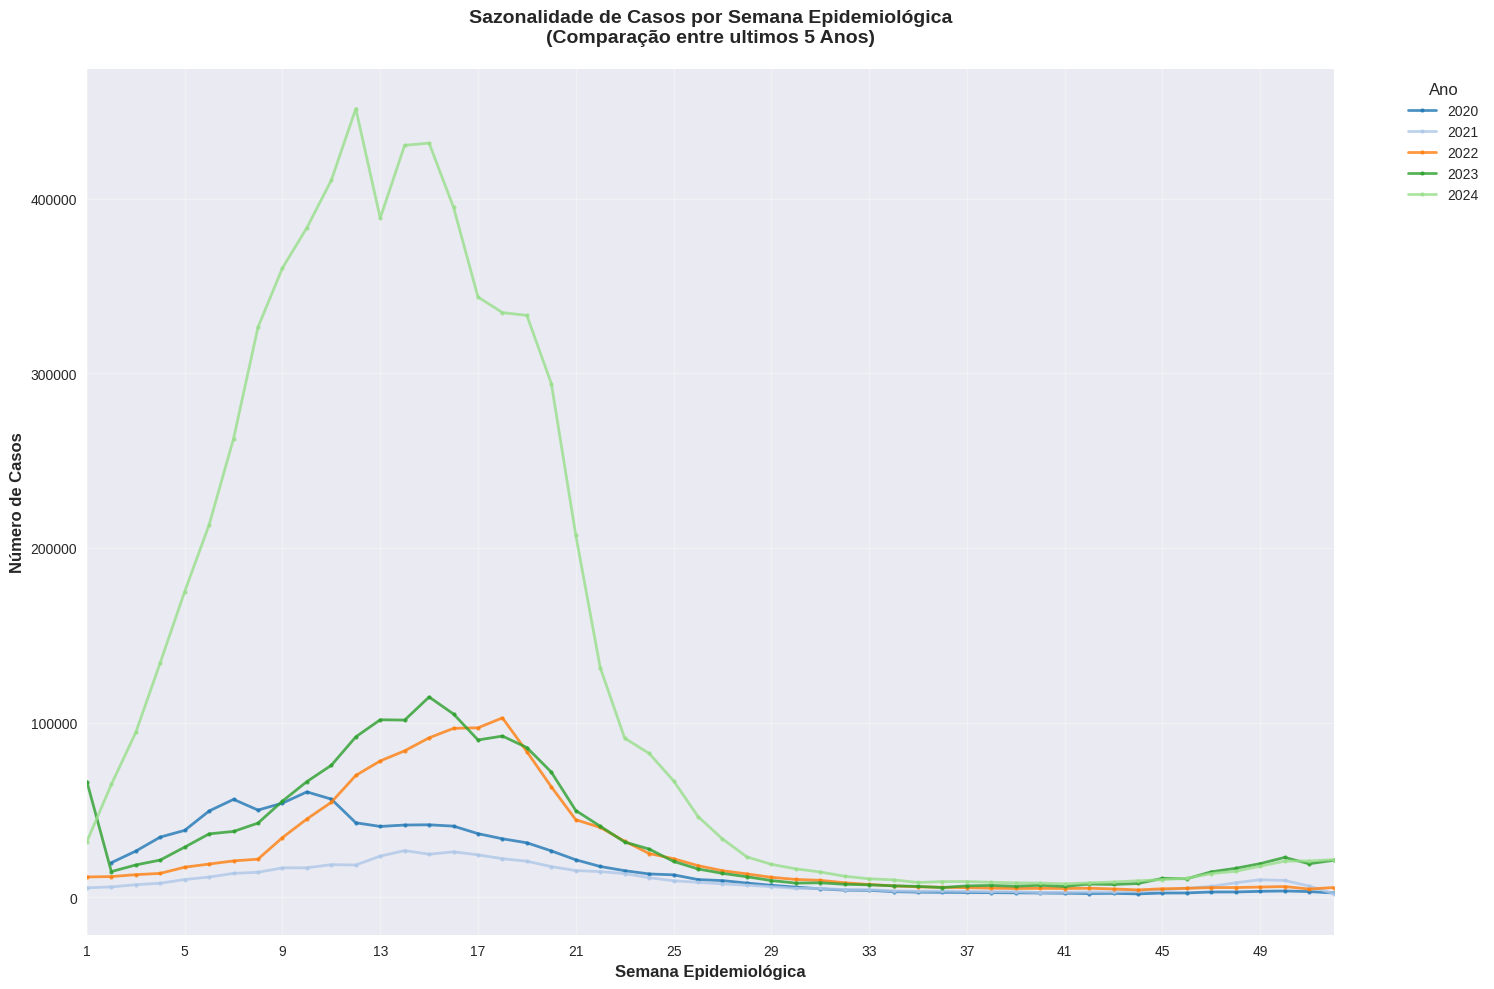

In [ ]:
# Agregar casos por ano e semana epidemiológica
casos_por_semana = final_df.groupby(['year', 'week'])['casos'].sum().reset_index()

# Criar matriz para o gráfico (anos como linhas, semanas como colunas)
pivot_data = casos_por_semana.pivot(index='year', columns='week', values='casos')

# Configurar o gráfico
fig, ax = plt.subplots(figsize=(15, 10))

# Gerar cores únicas para cada ano
anos = sorted(pivot_data.index)
cores = plt.cm.tab20(np.linspace(0, 1, len(anos)))

# Plotar cada ano como uma linha
for i, ano in enumerate([2020,2021,2022,2023,2024]):
    ax.plot(
        pivot_data.columns,
        pivot_data.loc[ano],
        label=str(ano),
        linewidth=2,
        color=cores[i],
        marker='o',
        markersize=3,
        alpha=0.8
    )

# Configurar o gráfico
ax.set_xlabel('Semana Epidemiológica', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Casos', fontsize=12, fontweight='bold')
ax.set_title('Sazonalidade de Casos por Semana Epidemiológica\n(Comparação entre ultimos 5 Anos)',
             fontsize=14, fontweight='bold', pad=20)

# Configurar eixo x
ax.set_xticks(range(1, 53, 4))  # Mostrar a cada 4 semanas
ax.set_xlim(1, 52)
ax.grid(True, alpha=0.3)

# Configurar legenda
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
          title='Ano', title_fontsize=12, fontsize=10)

# Ajustar layout
plt.tight_layout()

In [ ]:
def criar_analise_temporal_regioes(df):
    """
    Cria análise temporal das cinco regiões do Brasil em um único gráfico
    Agrupa por 'macroregional_name' e mostra evolução temporal
    """

    # Preparação dos dados
    df_temp = df.copy()

    # Agrupar por data e região
    casos_por_regiao_data = df_temp.groupby(['date', 'macroregion_name'])['casos'].sum().reset_index()

    # Criar figura com subplots organizados
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Análise Temporal de Casos por Região do Brasil', fontsize=20, fontweight='bold')

    # Definir cores consistentes para as regiões
    regioes = casos_por_regiao_data['macroregion_name'].unique()
    cores_regioes = {
        'Norte': '#2E8B57',      # Verde mar
        'Nordeste': '#FF6347',   # Vermelho tomate
        'Centro-Oeste': '#FFD700', # Dourado
        'Sudeste': '#4169E1',    # Azul royal
        'Sul': '#8A2BE2'         # Azul violeta
    }

    # 1. Série temporal principal - todas as regiões
    # ax_principal = axes[0, [0, 1]]
    ax_principal = plt.subplot(2, 1, 1)  # linha superior

    # Plot de cada região
    for regiao in regioes:
        dados_regiao = casos_por_regiao_data[casos_por_regiao_data['macroregion_name'] == regiao]

        # Calcular média móvel de 30 dias
        # dados_regiao = dados_regiao.sort_values('date')
        # dados_regiao['media_movel'] = dados_regiao['casos'].rolling(window=30, center=True).mean()

        cor = cores_regioes.get(regiao)

        # Linha principal
        ax_principal.plot(dados_regiao['date'], dados_regiao['casos'],
                         alpha=0.8, linewidth=2, color=cor)

        # Média móvel
        # ax_principal.plot(dados_regiao['date'], dados_regiao['media_movel'],
        #                  linewidth=3, alpha=0.9, color=cor, label=regiao)

    ax_principal.set_title('Evolução Temporal dos Casos por Região',
                          fontsize=16, fontweight='bold', pad=20)
    ax_principal.set_xlabel('Data', fontsize=12)
    ax_principal.set_ylabel('Número de Casos', fontsize=12)
    ax_principal.legend(loc='upper right', fontsize=11)
    ax_principal.grid(True, alpha=0.3)

    # 2. Análise semanal por região (parte inferior esquerda)
    ax_semanal = plt.subplot(2, 2, 3)

    # Extrair semana do ano
    df_temp['semana_ano'] = df_temp['epiweek'] % 100
    casos_semanal_regiao = df_temp.groupby(['semana_ano', 'macroregion_name'])['casos'].sum().reset_index()

    # Plotar sazonalidade semanal para cada região
    for regiao in regioes:
        dados_regiao_sem = casos_semanal_regiao[casos_semanal_regiao['macroregion_name'] == regiao]
        cor = cores_regioes.get(regiao, np.random.choice(['#FF1493', '#00CED1', '#FF8C00', '#9370DB', '#32CD32']))

        ax_semanal.plot(dados_regiao_sem['semana_ano'], dados_regiao_sem['casos'],
                       marker='o', markersize=3, linewidth=2, alpha=0.8,
                       color=cor, label=regiao)

    ax_semanal.set_title('Sazonalidade Semanal por Região', fontsize=14, fontweight='bold')
    ax_semanal.set_xlabel('Semana do Ano', fontsize=11)
    ax_semanal.set_ylabel('Total de Casos', fontsize=11)
    ax_semanal.legend(fontsize=9)
    ax_semanal.grid(True, alpha=0.3)

    # 3. Proporção de casos por região ao longo do tempo (parte inferior direita)
    ax_proporcao = plt.subplot(2, 2, 4)

    # Calcular proporção mensal
    df_temp['ano_mes'] = df_temp['date'].dt.to_period('M')
    casos_mensais = df_temp.groupby(['ano_mes', 'macroregion_name'])['casos'].sum().reset_index()

    # Calcular total mensal para proporções
    total_mensal = casos_mensais.groupby('ano_mes')['casos'].sum().reset_index()
    total_mensal.columns = ['ano_mes', 'total_casos']

    casos_mensais = casos_mensais.merge(total_mensal, on='ano_mes')
    casos_mensais['proporcao'] = casos_mensais['casos'] / casos_mensais['total_casos'] * 100

    # Preparar dados para área empilhada
    pivot_prop = casos_mensais.pivot(index='ano_mes', columns='macroregion_name', values='proporcao')
    pivot_prop = pivot_prop.fillna(0)

    # Converter índice para datetime para plotagem
    datas_mes = [pd.to_datetime(str(periodo)) for periodo in pivot_prop.index]

    # Criar gráfico de área empilhada
    cores_list = [cores_regioes.get(col, '#888888') for col in pivot_prop.columns]
    ax_proporcao.stackplot(datas_mes, *[pivot_prop[col] for col in pivot_prop.columns],
                          labels=pivot_prop.columns, colors=cores_list, alpha=0.8)

    ax_proporcao.set_title('Proporção de Casos por Região (%)', fontsize=14, fontweight='bold')
    ax_proporcao.set_xlabel('Data', fontsize=11)
    ax_proporcao.set_ylabel('Proporção (%)', fontsize=11)
    ax_proporcao.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
    ax_proporcao.grid(True, alpha=0.3)
    ax_proporcao.set_ylim(0, 100)

    # plt.tight_layout()
    plt.show()

    return casos_por_regiao_data, casos_semanal_regiao, casos_mensais

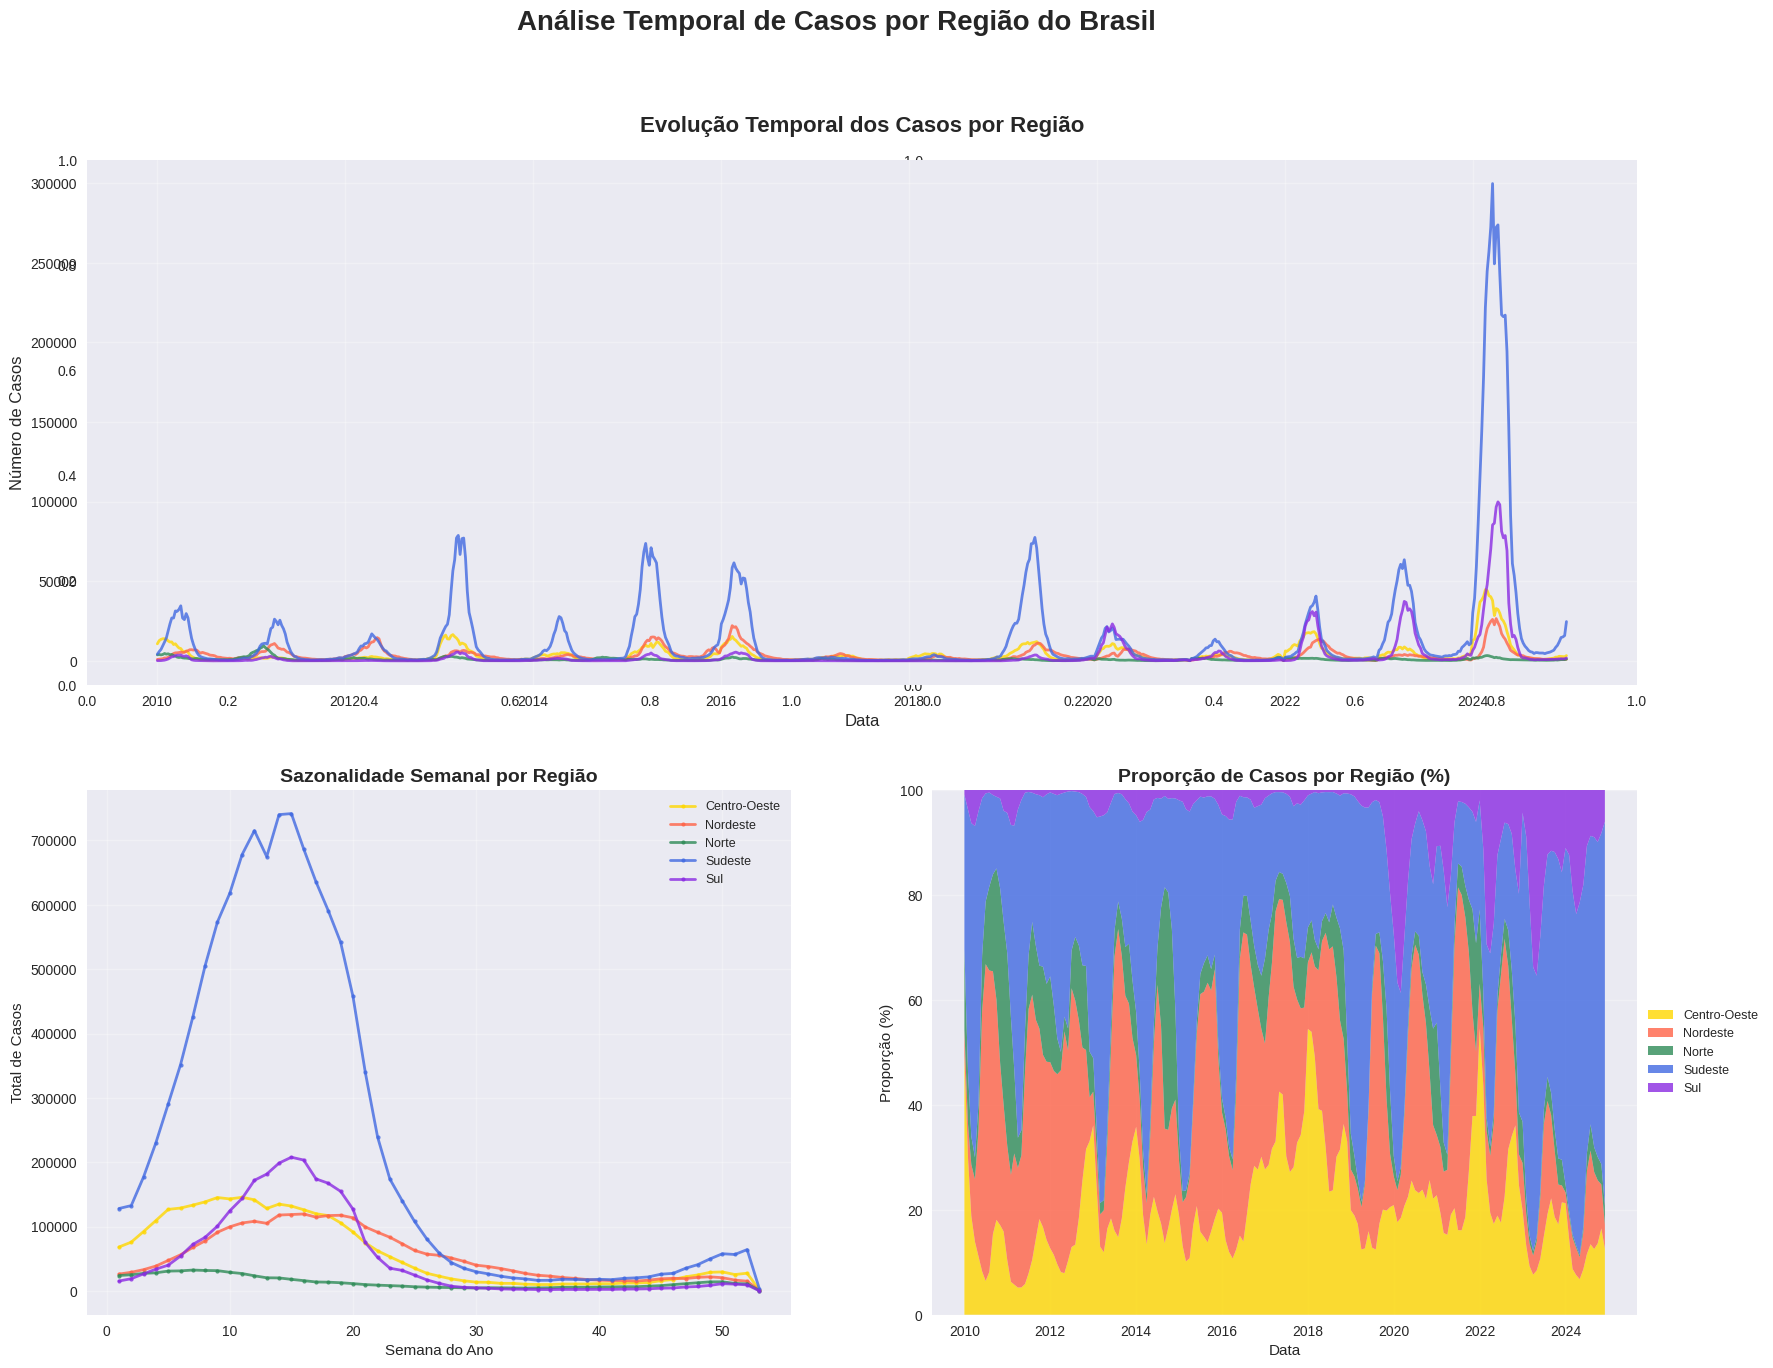

In [ ]:
# Executar análise por regiões
casos_regiao_data, casos_semanal_regiao, casos_mensais = criar_analise_temporal_regioes(final_df)

In [ ]:
def corr_matrix(data, cmap='divergent'):
    """
    It reads a dataframe and show a Lower Triangle Correlation Matrix.

    Parameters
    ------
        data: dataframe
        cmap: string - representing cmap type (default='divergent' or 'sequencial')

    Returns
    ------
        NoneType: only show correlation matrix during function execution/call

    Examples
    ------
        corr_matrix(data, cmap)
    """
    # Lower Triangle Correlation Matrix
    corr_df = data.corr()
    corr_shape = corr_df.shape
    tri_df = corr_df.where(np.tril(np.ones(corr_shape)).astype(bool))

    # Figure Ploting parameters
    if cmap == "sequential":
        cmap = "rocket"
    else:
        cmap = "coolwarm"

    plt.figure(figsize=(corr_shape))
    sns.heatmap(tri_df, linewidths=0.5, annot=True, cmap=cmap).set_title('Correlation Matrix')
    plt.xticks(rotation=40, ha='right')

    return

In [ ]:
print(list(final_df.columns))

['date', 'epiweek', 'geocode', 'casos', 'uf', 'macroregional_geocode', 'regional_geocode', 'temp_min', 'temp_med', 'temp_max', 'precip_min', 'precip_med', 'precip_max', 'pressure_min', 'pressure_med', 'pressure_max', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days', 'macroregion_code', 'macroregion_name', 'uf_code', 'uf_name', 'macroregional_name', 'regional_name', 'geocode_name', 'year', 'week', 'population']


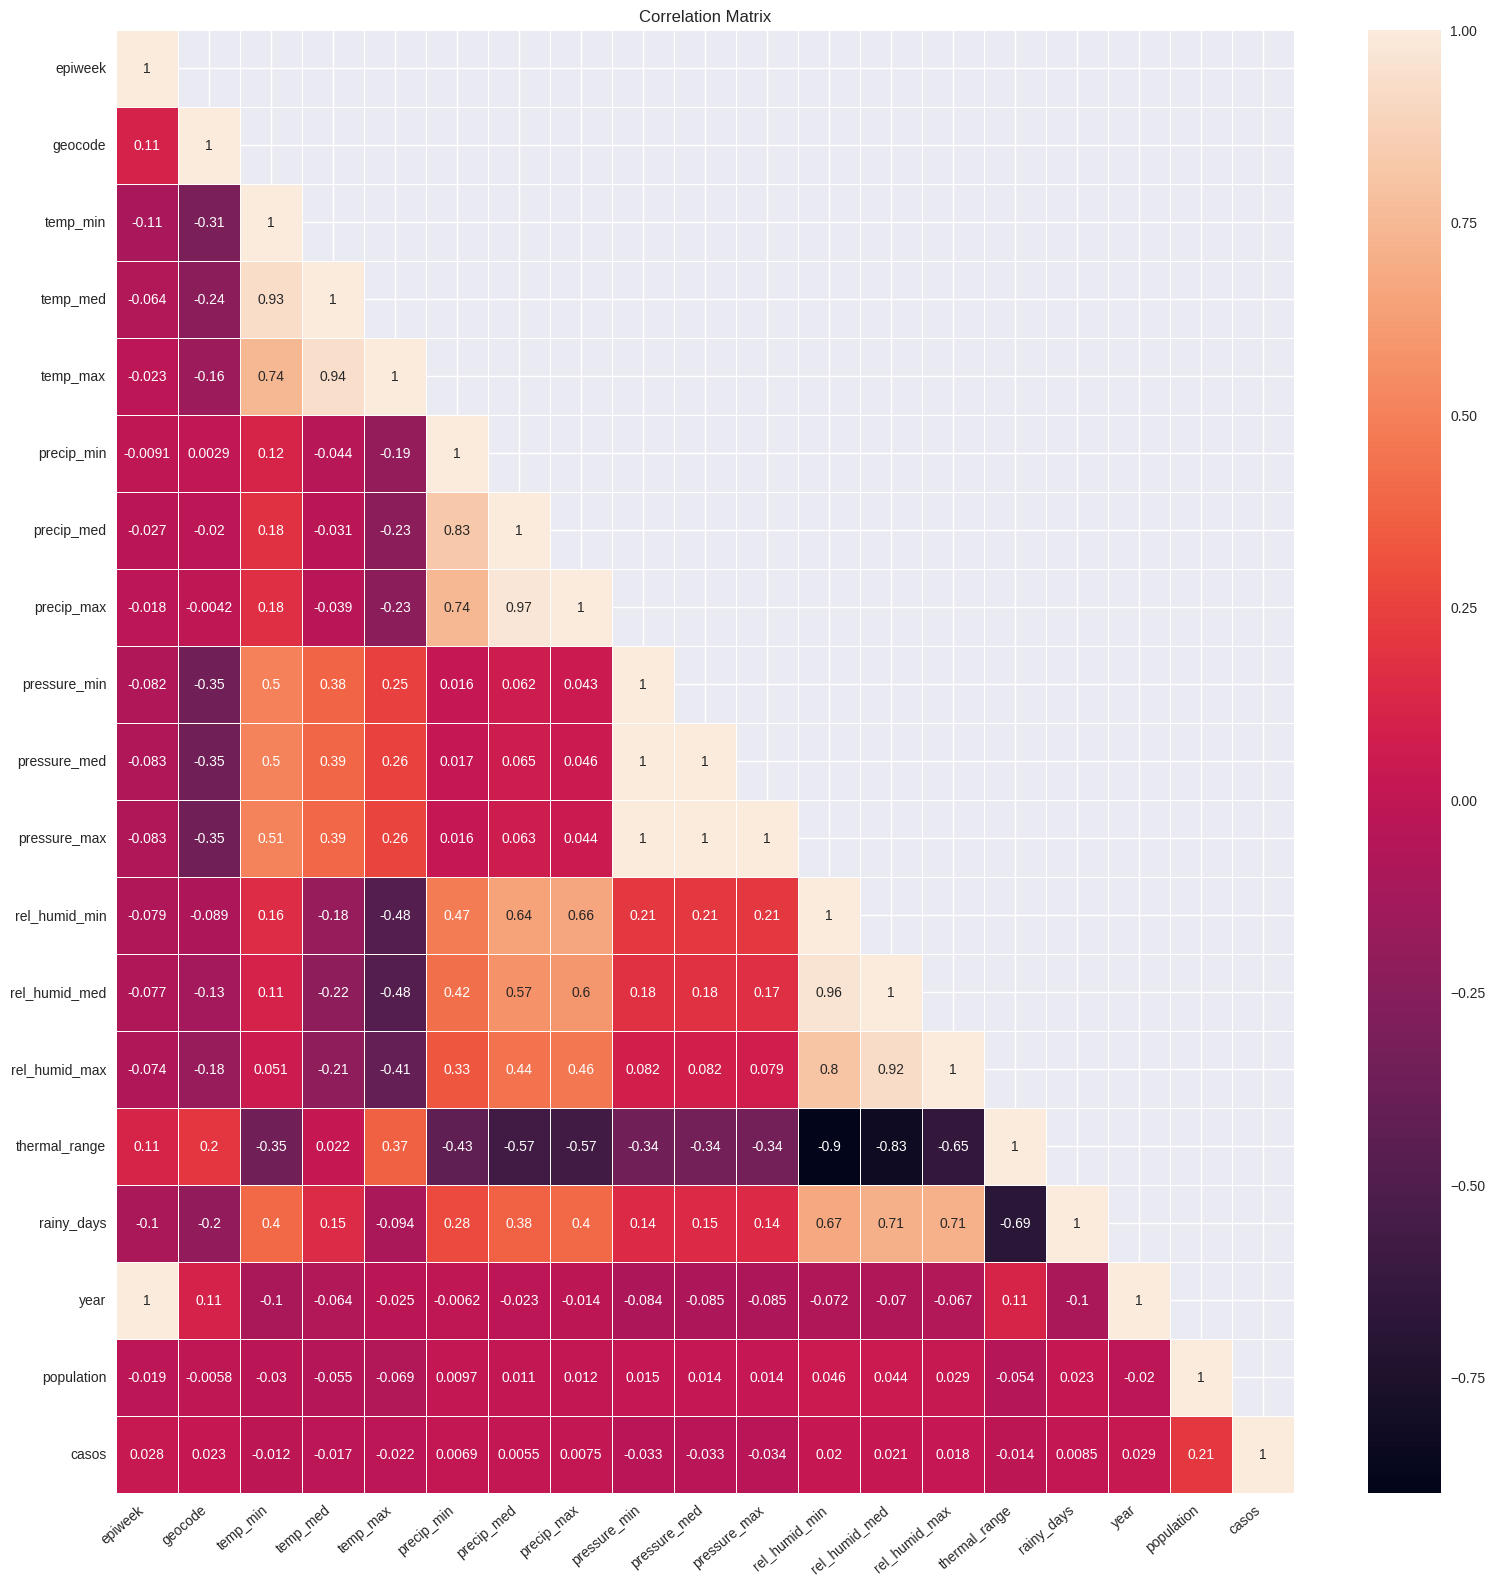

In [ ]:
columns = ['epiweek', 'geocode', 'temp_min', 'temp_med', 'temp_max', 'precip_min', 'precip_med', 'precip_max',
           'pressure_min', 'pressure_med', 'pressure_max', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
           'thermal_range', 'rainy_days', 'year', 'population', 'casos']
corr_matrix(final_df_nao_nulo[columns],cmap='sequential')
plt.show()

___
# 🎯 Criação de coluna para *target* de classificador
___

Estratificação de risco de ocorrência de dengue em patamares e baseada na taxa de incidência, calculada abaixo:
$$\frac{Número\;de\;casos}{População\;local} \times 100\;mil$$
Os patamares da coluna `risco_dengue` serão computados da seguinte forma:
- **`0 = Baixo risco`**: Incidência de até 100 casos/100 mil habitantes.

- **`1 = Médio risco`**: Incidência acima de 100 até 300 casos/100 mil habitantes.

- **`2 = Alto risco`**: Incidência superior a 300 casos/100 mil habitantes.

A Organização Mundial da Saúde (OMS) considera que taxas acima de 300 casos por 100 mil habitantes indicam situação epidêmica.

In [ ]:
# Função para criar a coluna risco_dengue usando np.where
def criar_coluna_risco_dengue(df):
    """
    Cria a coluna 'risco_dengue' baseada na taxa de incidência
    """
    # Calcular taxa de incidência
    df['taxa_incidencia'] = (df['casos'] / df['population']) * 100000

    # Criar coluna risco_dengue baseada na taxa de incidência
    df['risco_dengue'] = np.where(df['taxa_incidencia'] <= 100, 0,
                                 np.where(df['taxa_incidencia'] <= 300, 1, 2))

    return df

In [ ]:
df_classificado = criar_coluna_risco_dengue(final_df)

In [ ]:
# Verificando limites dos intervalos discretos
intervalos_df = df_classificado[['taxa_incidencia', 'risco_dengue']]
display(intervalos_df[intervalos_df['taxa_incidencia'] < 100].head(3))
display(intervalos_df[intervalos_df['taxa_incidencia'] == 100].head(3))
display(intervalos_df[(intervalos_df['taxa_incidencia'] >= 100) & (intervalos_df['taxa_incidencia'] <= 105)].head(3))
display(intervalos_df[intervalos_df['taxa_incidencia'] == 300].head(3))
display(intervalos_df[intervalos_df['taxa_incidencia'] > 300].head(3))

,taxa_incidencia,risco_dengue
0,11.955049,0
1,13.110885,0
2,30.599755,0


,taxa_incidencia,risco_dengue
892366,100.0,0
1257737,100.0,0
1759686,100.0,0


,taxa_incidencia,risco_dengue
14,102.137221,1
5101,100.923341,1
5226,101.844517,1


,taxa_incidencia,risco_dengue
920156,300.0,1
2705415,300.0,1
4249062,300.0,1


,taxa_incidencia,risco_dengue
9,590.841950,2
10,371.461269,2
19,360.300705,2


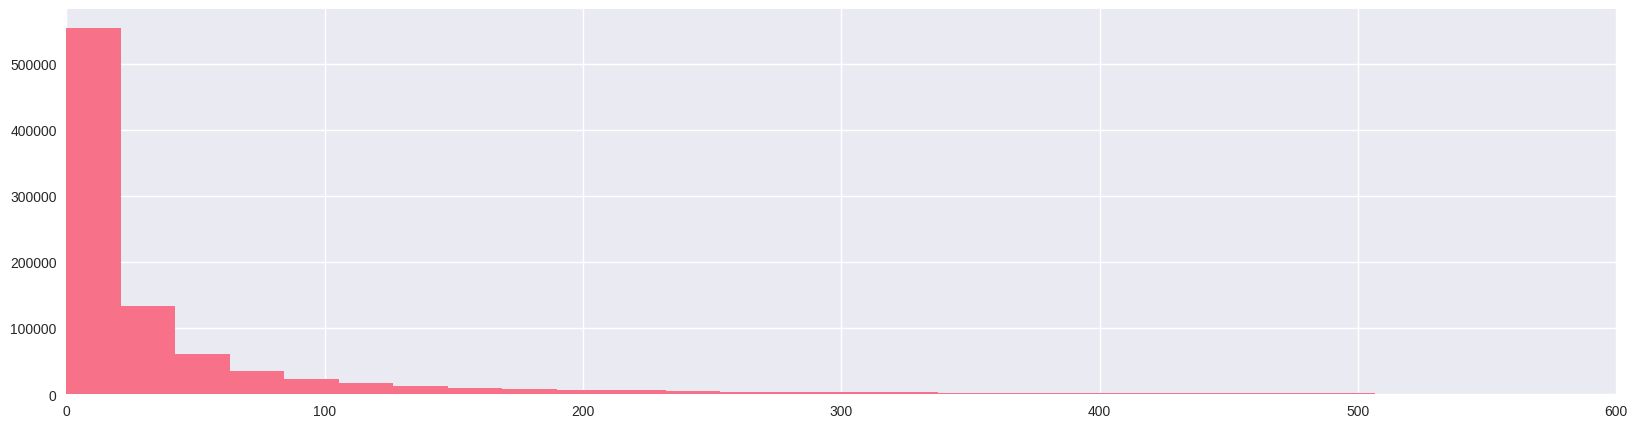

In [ ]:
# Plot histogram for the 'column_name'
df_classificado_sem_nulos = df_classificado[df_classificado['casos'] > 0]
ax_hist = df_classificado_sem_nulos['taxa_incidencia'].hist(bins=300, figsize=(20, 5))
# Set the x-axis limits
ax_hist.set_xlim(0, 600)
# Display the plot
plt.show()

___
# Exportação do dataset para treinamento
___

In [ ]:
colunas_filtradas = ['year', 'week', 'macroregion_code', 'uf_code', 'geocode', 'temp_min', 'temp_med', 'temp_max', 'precip_med',
                     'rel_humid_med', 'thermal_range', 'rainy_days', 'population', 'casos', 'taxa_incidencia', 'risco_dengue']

In [ ]:
# Filtrando dados de 2020 até 2024 com 'casos' > 0
filtered_df = df_classificado[(df_classificado['year'] >= 2020) & (df_classificado['year'] <= 2024)][colunas_filtradas]
filtered_df = filtered_df[filtered_df['casos'] > 0]
filtered_df.to_csv('dataset_com_casos_2020_2024.csv', index=False)
print(filtered_df.info())
filtered_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 385312 entries, 2895822 to 4352489
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              385312 non-null  int32  
 1   week              385312 non-null  int64  
 2   macroregion_code  385312 non-null  int64  
 3   uf_code           385312 non-null  int64  
 4   geocode           385312 non-null  int64  
 5   temp_min          385312 non-null  float64
 6   temp_med          385312 non-null  float64
 7   temp_max          385312 non-null  float64
 8   precip_med        385312 non-null  float64
 9   rel_humid_med     385312 non-null  float64
 10  thermal_range     385312 non-null  float64
 11  rainy_days        385312 non-null  int64  
 12  population        385312 non-null  int64  
 13  casos             385312 non-null  int64  
 14  taxa_incidencia   385312 non-null  float64
 15  risco_dengue      385312 non-null  int64  
dtypes: float64(7), int

,year,week,macroregion_code,uf_code,geocode,temp_min,temp_med,temp_max,precip_med,rel_humid_med,thermal_range,rainy_days,population,casos,taxa_incidencia,risco_dengue
2895822,2020,2,2,27,2709400,22.336300,26.108757,31.704586,0.5010,69.067000,9.368286,5,24953,7,28.052739,0
2895827,2020,2,2,27,2707701,24.149371,26.807443,30.632171,2.9335,72.190414,6.482800,7,88622,1,1.128388,0
2895850,2020,2,2,27,2706901,24.070043,26.917100,31.077514,2.6849,72.441900,7.007471,7,35908,1,2.784895,0
2895865,2020,2,2,27,2706307,22.574771,26.787957,32.937343,0.1469,64.596786,10.362571,5,73148,1,1.367091,0
2895869,2020,2,2,27,2704005,23.779543,27.358014,32.730043,0.8709,67.288800,8.950500,6,24523,1,4.077805,0
